# CNN을 이용한 문서 분류

**NLTK 영화 리뷰 데이터 준비**

In [1]:
import nltk
nltk.download('movie_reviews')

from nltk.corpus import movie_reviews

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [2]:
# movie review data에서 file id를 가져옴
fileids = movie_reviews.fileids() 
# file id를 이용해 raw text file을 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids]
# file id를 이용해 label로 사용할 category 즉 positive와 negative 정보를 순서대로 가져옴
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]

print('Reviews count:', len(reviews))
print('Length of the first review:', len(reviews[0]))
print('Labels:', set(categories))

Reviews count: 2000
Length of the first review: 4043
Labels: {'neg', 'pos'}


**토크나이징 및 데이터 구축**

In [3]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000   # 사용할 단어의 수

# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')
tokenizer.fit_on_texts(reviews)     # 단어 인덱스 구축

X = tokenizer.texts_to_sequences(reviews)   # 만들어진 단어 인덱스를 이용해 문서들을 변환

print('Lengths of first 10 documents:', [len(doc) for doc in X[:10]])

Lengths of first 10 documents: [710, 240, 486, 479, 733, 671, 550, 584, 702, 776]


In [5]:
print("Index of 'the':", tokenizer.word_index["the"])
print("Index of 'review':", tokenizer.word_index["review"])
print("Index of out-of-vocabulary words:", tokenizer.word_index["UNK"])

Index of 'the': 2
Index of 'review': 466
Index of out-of-vocabulary words: 1


In [6]:
maxlen = 500    # 문서의 단어 수를 제한

# 문서의 단어 수가 500보다 작으면 0을 채우고, 크면 잘라냄
# 잘라낼 때, 앞을 자를 지, 뒤를 자를 지 선택할 수 있음. 앞을 자르고 뒷부분을 쓰고자 하면 'pre' 선택
X = pad_sequences(X, maxlen=maxlen, truncating='pre')

In [7]:
# label을 0, 1의 값으로 변환
label_dict = {'pos':1, 'neg':0}
y = np.array([label_dict[c] for c in categories])
print(set(y))

{0, 1}


**훈련, 테스트 데이터 분리**

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1]


**CNN 모형 생성**

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D
from keras.layers import Embedding, Dropout, Flatten
from keras.optimizers import adam_v2

In [13]:
model = Sequential([
    # word embedding layer 생성
    Embedding(max_words, 64, input_length=maxlen), 
    Conv1D(128,     # 채널의 수
            5,      # 1D 필터 크기
            padding='valid', 
            activation='relu',
            strides=1),
    MaxPooling1D(),
    Conv1D(256,     # 채널의 수
            5,      # 1D 필터 크기
            padding='valid', 
            activation='relu',
            strides=1),
    MaxPooling1D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # binary logistic regression을 수행
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 496, 128)          41088     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 248, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 244, 256)          164096    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 122, 256)         0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 31232)             0

**모델 학습**

In [14]:
# Adam의 학습율 설정
adam = adam_v2.Adam(learning_rate=1e-3)
# 모형의 optimizer와 loss function 등을 지정
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
# 학습
history = model.fit(X_train,
                    y_train, 
                    epochs=20,
                    batch_size=256,
                    verbose=1,      # 진행률 표시
                    validation_split=0.2)   # 훈련 데이터중 20%는 검증 데이터로 사용

Epoch 1/20
5/5 [==============================] - 13s 108ms/step - loss: 0.7092 - acc: 0.4969 - val_loss: 0.6942 - val_acc: 0.4969
Epoch 2/20
5/5 [==============================] - 0s 49ms/step - loss: 0.6932 - acc: 0.4969 - val_loss: 0.6930 - val_acc: 0.4969
Epoch 3/20
5/5 [==============================] - 0s 51ms/step - loss: 0.6924 - acc: 0.5477 - val_loss: 0.6926 - val_acc: 0.5219
Epoch 4/20
5/5 [==============================] - 0s 49ms/step - loss: 0.6908 - acc: 0.5336 - val_loss: 0.6916 - val_acc: 0.5188
Epoch 5/20
5/5 [==============================] - 0s 49ms/step - loss: 0.6864 - acc: 0.5898 - val_loss: 0.6904 - val_acc: 0.5281
Epoch 6/20
5/5 [==============================] - 0s 48ms/step - loss: 0.6763 - acc: 0.6703 - val_loss: 0.6874 - val_acc: 0.5469
Epoch 7/20
5/5 [==============================] - 0s 48ms/step - loss: 0.6487 - acc: 0.7922 - val_loss: 0.6716 - val_acc: 0.5750
Epoch 8/20
5/5 [==============================] - 0s 47ms/step - loss: 0.5805 - acc: 0.8055 - v

**모델의 손실값, 정확도 그래프화**

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label='Training '+metric)
    plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
    plt.title('Training vs. Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

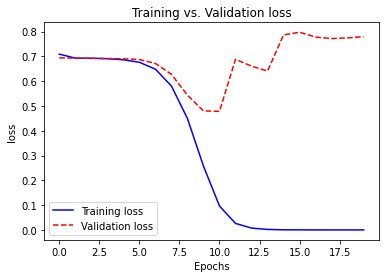

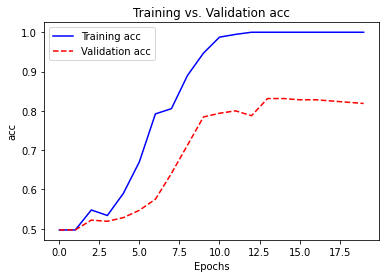

In [16]:
plot_results(history, 'loss')
plot_results(history, 'acc')

**모델 평가**

In [17]:
# 테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'Test accuracy:{score[1]:.3f}')

13/13 [==============================] - 0s 9ms/step - loss: 0.8070 - acc: 0.8000
Test accuracy:0.800
